In [3]:
import networkx as nx
from fa2 import ForceAtlas2  #the package should be installed before
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import mean, median, quantiles
from networkx.algorithms.traversal.breadth_first_search import descendants_at_distance
import time
import requests
import glob
import pickle
import numpy as np
import copy

# IMPORT THE STATISTICS DICTIONARIES BUILT BEFOREHAND

In [4]:
subfolders = ["total"] #, "total_normalizedNumComm"]
dictionaries = [] #puppiesTotal, PoliticalTotal, puppiesNorma, PoliticalNorma
subreddits = ["puppies", "PoliticalDiscussion"]

for subfolder in subfolders:
    for subreddit in subreddits:
        with open('stat_'+subreddit+'_'+subfolder+'.pickle', 'rb') as handle:
            dictionaries.append(pickle.load(handle))


In [5]:
def plot_features(allStat,statAux,feature,division):
    
    stats = {}
    for ids in allStat:
        for stat in allStat[ids][feature]:
            if stat in stats:
                if allStat[ids][feature][stat]!=0 and allStat[ids][feature][stat]!=1:
                    stats[stat].append(allStat[ids][feature][stat]/division)
            else:
                stats[stat]=[allStat[ids][feature][stat]/division]
    
    for i,stat in enumerate(stats):
        axs[i].hist(stats[stat], bins=40, log=True)
        axs[i].set_title(stat)

In [6]:
def plot_features_all(dictions, subreddits, feature, sharex):
    fig = plt.figure(constrained_layout=True, figsize=(20,4*len(dictions)))
    fig.suptitle('Distribution of '+feature)
    
    # create 2x1 subfigs
    subfigs = fig.subfigures(nrows=len(subreddits), ncols=1)
    axs_prev = []
    ncol=4
    division=1
    if feature=="authorStats":
        ncol=6
    if feature=="timeStats":
        division=86400
    
    
    stats0 = {}
    for ids in dictions[0]:
        for stat in dictions[0][ids][feature]:
            if stat in stats0:
                if dictions[0][ids][feature][stat]!=0 and dictions[0][ids][feature][stat]!=1:
                    stats0[stat].append(dictions[0][ids][feature][stat]/division)
            else:
                stats0[stat]=[dictions[0][ids][feature][stat]/division]
    
    stats1 = {}
    for ids in dictions[1]:
        for stat in dictions[1][ids][feature]:
            if stat in stats1:
                if dictions[1][ids][feature][stat]!=0 and dictions[1][ids][feature][stat]!=1:
                    stats1[stat].append(dictions[1][ids][feature][stat]/division)
            else:
                stats1[stat]=[dictions[1][ids][feature][stat]/division]
    
    mins = [10000 for i in range(len(stats0))]
    maxs = [-10000 for i in range(len(stats0))]
    
    for i, stat in enumerate(stats0):
        for elem in stats0[stat]:
            if elem < mins[i]:
                mins[i]=elem
            if elem > maxs[i]:
                maxs[i] = elem
    
    for i, stat in enumerate(stats1):
        for elem in stats1[stat]:
            if elem < mins[i]:
                mins[i]=elem
            if elem > maxs[i]:
                maxs[i] = elem
                
    #print(mins)
    #print(maxs)
    steps = 40
        
    subfigs[0].suptitle(subreddits[0])
    # create 1x3 subplots per subfig
    axs = subfigs[0].subplots(nrows=1, ncols=ncol)
    
    for i,stat in enumerate(stats0):
        binSS = np.linspace(mins[i], maxs[i],steps)
        axs[i].hist(stats0[stat], bins=binSS, log=True)
        axs[i].set_title(stat)
    
    axs_prev = axs
    axs = subfigs[1].subplots(nrows=1, ncols=ncol)
    if sharex == True:
        for i in range(len(axs)):
            axs[i].get_shared_x_axes().join(axs[i], axs_prev[i])
            axs_prev[i].set_xticklabels([])
    
    subfigs[1].suptitle(subreddits[1])
    
    for i,stat in enumerate(stats1):
        binSS = np.linspace(mins[i], maxs[i], steps)
        axs[i].hist(stats1[stat], bins=binSS, log=True)
        axs[i].set_title(stat)
    

In [7]:
dictionaries.append({})
dictionaries.append({})
dictionaries.append({})
dictionaries.append({})

In [8]:
num_users1 = []
for t in dictionaries[1]:
    num_users1.append(dictionaries[1][t]["commStats"]["num_comments"])
    
num_users0 = []
for t in dictionaries[0]:
    num_users0.append(dictionaries[0][t]["commStats"]["num_comments"])

In [9]:
binss = np.arange(10,170,20)
min(num_users1)

3.0

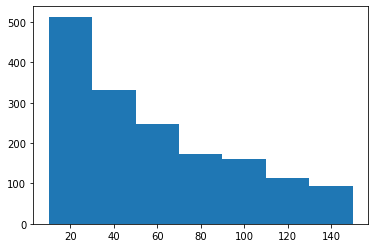

In [10]:
a = plt.hist(num_users1, bins=binss)
#plt.hist(num_users0, bins=binss)

(array([512.,  20.,   5.,   0.,   1.,   0.,   1.]),
 array([ 10,  30,  50,  70,  90, 110, 130, 150]),
 <BarContainer object of 7 artists>)

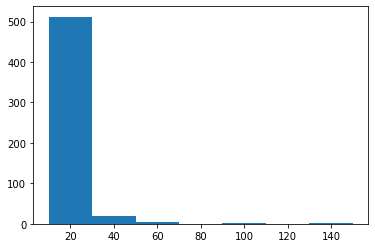

In [11]:
plt.hist(num_users0, bins=binss)

### 1029 VERSION: Submissions with a number of comments between 10 and 29

In [12]:
for key in dictionaries[0]:
    num_comm = dictionaries[0][key]["commStats"]["num_comments"]
    if num_comm < 30 and num_comm >=10:
        dictionaries[2][key] = copy.deepcopy(dictionaries[0][key])

In [13]:
for key in dictionaries[1]:
    num_comm = dictionaries[1][key]["commStats"]["num_comments"]
    if num_comm < 30 and num_comm >=10:
        dictionaries[3][key] = copy.deepcopy(dictionaries[1][key])

In [14]:
len(dictionaries[2])

512

### Equalised version: submissions with number of comments on both subreddits

In [15]:
keys0 = [k for k in list(dictionaries[0].keys())]
keys1 = [k for k in list(dictionaries[1].keys())]
n_comm0 = []
n_comm1 = []
for k in keys0:
    n_comm0.append(dictionaries[0][k]["commStats"]["num_comments"])
for k in keys1:
    n_comm1.append(dictionaries[1][k]["commStats"]["num_comments"])

In [16]:
for pos, num in enumerate(n_comm0):
    try:
        index = n_comm1.index(num)
        dictionaries[4][keys0[pos]] = copy.deepcopy(dictionaries[0][keys0[pos]])
        dictionaries[5][keys1[index]] = copy.deepcopy(dictionaries[1][keys1[index]])
        del keys1[index]
        del n_comm1[index]
    except:
        index = 1

In [17]:
len(dictionaries[5])

837

In [18]:
with open('stat_puppies_distrEqualized.pickle', 'wb') as handle:
    pickle.dump(dictionaries[4], handle)
with open('stat_PoliticalDiscussion_distrEqualized.pickle', 'wb') as handle:
    pickle.dump(dictionaries[5], handle)

### Visualization of the statistics

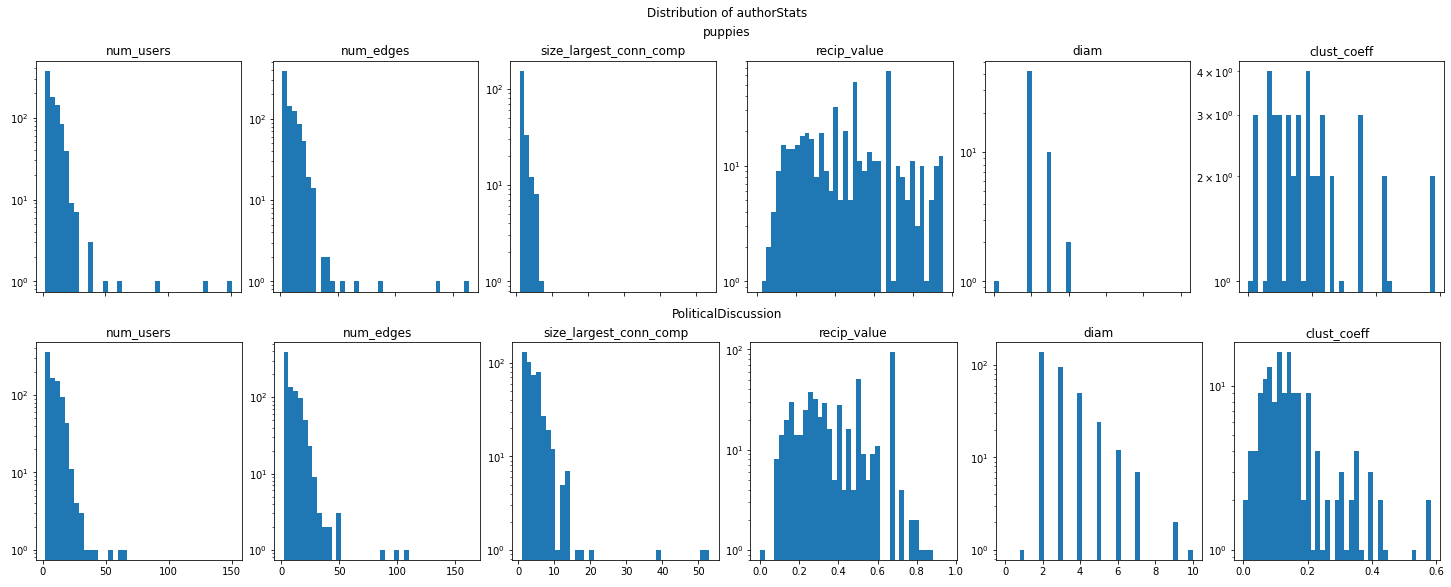

In [54]:
plot_features_all(dictionaries[4:], subreddits, "authorStats", sharex=True)  #normalized
#plot_features_all(dictionaries[:2], subreddits, "authorStats", sharex=False)  #NOT normalized

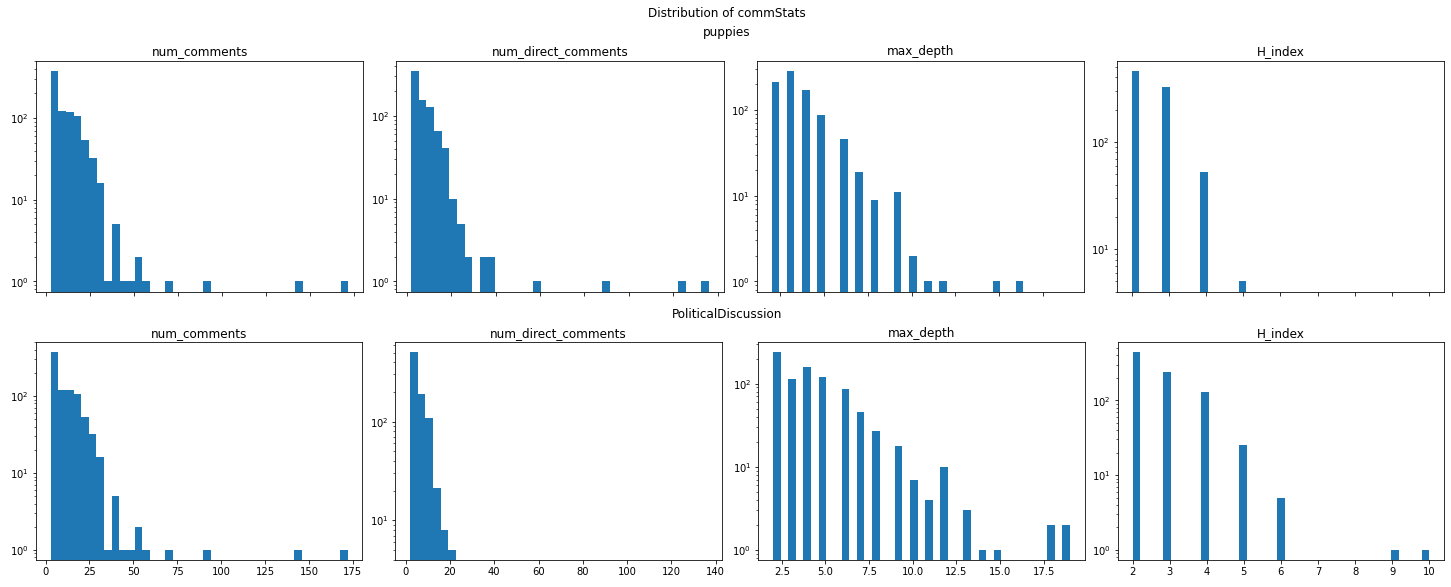

In [55]:
plot_features_all(dictionaries[4:], subreddits, "commStats", sharex=True)    #normalized
#plot_features_all(dictionaries[:2], subreddits, "commStats", sharex=False)  #NOT normalized

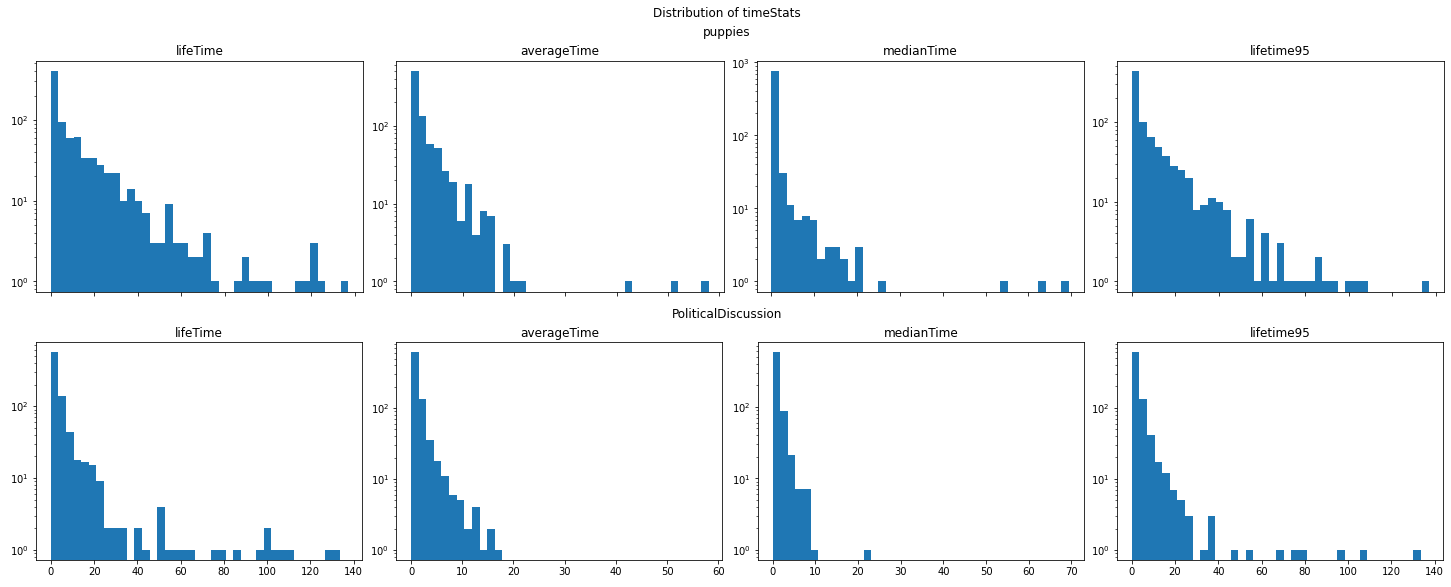

In [56]:
plot_features_all(dictionaries[4:], subreddits, "timeStats", sharex=True) #normalized
#plot_features_all(dictionaries[:2], subreddits, "timeStats", sharex=True)  #NOT normalized

In [11]:
def comm_temp_distr(subreddit):
    comNets = glob.glob("cG_prove_monthly_"+subreddit+"/total/*")
    creations = []
    for i,net in enumerate(comNets):
        #if i%500 == 0:
        #    print(i,"/",len(comNets))
        netId = net.split("_")[4]+"_"+net.split("_")[5]
        commentsGraph = nx.read_gpickle(net)
        creations.append(list(nx.get_node_attributes(commentsGraph,'created').values())[0])
    min_c=min(creations)
    plt.title("temporal distribution of the comments of "+subreddit)
    _=plt.hist([(x-min_c)/86400/30 for x in creations], bins=400)
    plt.show()

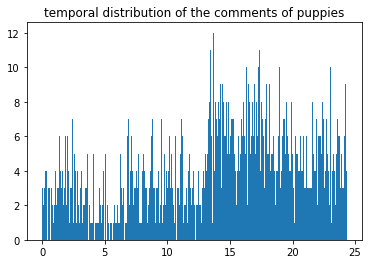

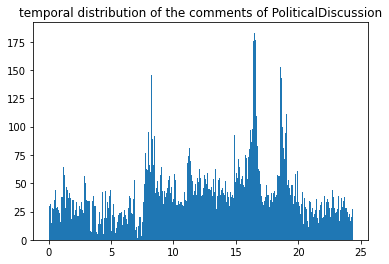

In [12]:
comm_temp_distr("puppies")
#comm_temp_distr("LGBTQ")
#comm_temp_distr("politics")
comm_temp_distr("PoliticalDiscussion")